# Etapa 1 | Carregamento, Pré-Processamento Inicial e Divisão dos Dados

In [38]:
# ETAPA 1.0 | Bibliotecas necessárias

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# ETAPA 1.1 | Carregar dados do Kaggle

def carregarDados(caminhoData: str) -> pd.DataFrame | None:
    """
    Carrega e unifica os arquivos CSV do Kaggle dataset
    ('time_domain', 'heart_rate_non_linear', 'frequency_domain').
    """

    dataframes = {}

    try:
        csvFiles = [f for f in os.listdir(caminhoData) if f.endswith('.csv')]

        if not csvFiles:
            print("ERRO: Nenhum arquivo CSV encontrado.")
            return None

        for fileName in csvFiles:
            fullPath = os.path.join(caminhoData, fileName)
            dfTemp = pd.read_csv(fullPath)

            keyName = fileName.split('.csv')[0]
            dataframes[keyName] = dfTemp
            print(f"✅ Carregado: {keyName} - {dfTemp.shape}")

    except Exception as e:
        print(f"Erro ao carregar: {e}")
        return None

    # Tentando identificar automaticamente quais são time / nonlinear / freq
    possiveisChaves = list(dataframes.keys())

    def buscarChave(texto):
        for key in possiveisChaves:
            if texto in key.lower():
                return key
        return None

    chaveTime = buscarChave('time')
    chaveNonLinear = buscarChave('non')
    chaveFreq = buscarChave('frequency')

    if not all([chaveTime, chaveNonLinear, chaveFreq]):
        print("ERRO: Arquivos esperados não encontrados corretamente.")
        print("Arquivos encontrados:", possiveisChaves)
        return None

    dfMerged = pd.merge(
        dataframes[chaveTime],
        dataframes[chaveNonLinear],
        on='uuid',
        how='inner'
    )

    dfFinal = pd.merge(
        dfMerged,
        dataframes[chaveFreq],
        on='uuid',
        how='inner'
    )

    print(f"\n✅ Dataset unificado com sucesso: {dfFinal.shape}")

    return dfFinal


In [40]:
# ETAPA 1.2 | Transformação inicial dos dados

def transformarDados(df: pd.DataFrame, colunaAlvo: str = 'HR'):
    """
    Separa variáveis preditoras (X) e alvo (Y),
    remove colunas irrelevantes e aplica One-Hot Encoding em 'condition'.
    """

    if df is None:
        print("ERRO: DataFrame vazio.")
        return None, None

    # Colunas que não agregam valor (apenas identificadores)
    colunasParaRemover = ['uuid', 'datasetId']

    # Variável alvo (formato coluna para álgebra linear)
    Y = df[colunaAlvo].values.reshape(-1, 1)

    # Variáveis preditoras (remove alvo + ids)
    X = df.drop(columns=[colunaAlvo] + colunasParaRemover, errors='ignore').copy()

    # One-Hot Encoding para variável categórica 'condition'
    # drop_first=True evita multicolinearidade perfeita
    if 'condition' in X.columns:
        X = pd.get_dummies(X, columns=['condition'], drop_first=True)

    return X, Y

In [41]:
# ETAPA 1.3 | Separação em treino e teste

def dividirTreinoTeste(X, Y, tamanhoTeste=0.2, estadoAleatorio=27):
    """
    Divide os dados em conjunto de treinamento e teste.
    """

    # Separação usando proporção definida (ex: 80% treino / 20% teste)
    XTrain, XTest, YTrain, YTest = train_test_split(
        X, Y, test_size=tamanhoTeste, random_state=estadoAleatorio
    )

    print(f"\n✅ Divisão do Conjunto de Dados: CONCLUÍDA!")
    print(f"   Treino: {XTrain.shape}")
    print(f"   Teste: {XTest.shape}")

    return XTrain, XTest, YTrain, YTest

In [42]:
# ETAPA 1.4 | Pré-processamento dos preditores

def preProcessarFeatures(XTrainRaw, XTestRaw):
    """
    Aplica transformação logarítmica, imputação e padronização (scaling).
    O ajuste é feito APENAS no conjunto de treino!
    """

    # 1. Transformação Log (reduzir assimetria)
    XTrainLog = np.log1p(XTrainRaw)
    XTestLog  = np.log1p(XTestRaw)

    # 2. Imputação (usa apenas estatísticas do TREINO)
    imputer = SimpleImputer(strategy='median')
    imputer.fit(XTrainLog)

    XTrainLog = pd.DataFrame(
        imputer.transform(XTrainLog),
        columns=XTrainRaw.columns,
        index=XTrainRaw.index
    )

    XTestLog = pd.DataFrame(
        imputer.transform(XTestLog),
        columns=XTestRaw.columns,
        index=XTestRaw.index
    )

    # 3. Padronização
    scaler = StandardScaler()
    XTrainScaled = scaler.fit_transform(XTrainLog)
    XTestScaled  = scaler.transform(XTestLog)

    # Recriar DataFrames
    XTrain = pd.DataFrame(XTrainScaled, columns=XTrainLog.columns, index=XTrainLog.index)
    XTest  = pd.DataFrame(XTestScaled, columns=XTestLog.columns, index=XTestLog.index)

    return XTrain, XTest, scaler


In [43]:
# com Yeo-Johnson!!!
'''
def preProcessarFeatures(XTrainRaw, XTestRaw):
    """
    Aplica transformação Yeo-Johnson e padronização (scaling).
    O ajuste é feito APENAS no conjunto de treino!
    """

    # 1. Transformação Yeo-Johnson
    # Diferente do log, aceita valores negativos!!!
    # Reduz assimetria e deixa as features mais próximas de uma distribuição normal
    pt = PowerTransformer(method='yeo-johnson')

    # Ajusta APENAS no treinamento (evita vazamento de dados)
    XTrainTransf = pt.fit_transform(XTrainRaw)
    # Aplica a MESMA transformação no conjunto de teste
    XTestTransf  = pt.transform(XTestRaw)

    # Reconstrói como DataFrame (mantém colunas e índices)
    XTrainTransf = pd.DataFrame(XTrainTransf, columns=XTrainRaw.columns, index=XTrainRaw.index
    )

    XTestTransf = pd.DataFrame(XTestTransf, columns=XTestRaw.columns, index=XTestRaw.index
    )

    # 2. Padronização
    # Necessária para modelos com regularização
    scaler = StandardScaler()

    # Ajusta no treino e aplica no teste
    XTrainScaled = scaler.fit_transform(XTrainTransf)
    XTestScaled  = scaler.transform(XTestTransf)

    # Reconstrói DataFrames finais
    XTrain = pd.DataFrame(XTrainScaled, columns=XTrainTransf.columns, index=XTrainTransf.index)
    XTest  = pd.DataFrame(XTestScaled, columns=XTestTransf.columns, index=XTestTransf.index)

    return XTrain, XTest, scaler
'''

'\ndef preProcessarFeatures(XTrainRaw, XTestRaw):\n    """\n    Aplica transformação Yeo-Johnson e padronização (scaling).\n    O ajuste é feito APENAS no conjunto de treino!\n    """\n\n    # 1. Transformação Yeo-Johnson\n    # Diferente do log, aceita valores negativos!!!\n    # Reduz assimetria e deixa as features mais próximas de uma distribuição normal\n    pt = PowerTransformer(method=\'yeo-johnson\')\n\n    # Ajusta APENAS no treinamento (evita vazamento de dados)\n    XTrainTransf = pt.fit_transform(XTrainRaw)\n    # Aplica a MESMA transformação no conjunto de teste\n    XTestTransf  = pt.transform(XTestRaw)\n\n    # Reconstrói como DataFrame (mantém colunas e índices)\n    XTrainTransf = pd.DataFrame(XTrainTransf, columns=XTrainRaw.columns, index=XTrainRaw.index\n    )\n\n    XTestTransf = pd.DataFrame(XTestTransf, columns=XTestRaw.columns, index=XTestRaw.index\n    )\n\n    # 2. Padronização\n    # Necessária para modelos com regularização\n    scaler = StandardScaler()\n\n  

In [44]:
# EXECUÇÃO DA ETAPA 1 | Pipeline Completo

# 1.
path = kagglehub.dataset_download("vinayakshanawad/heart-rate-prediction-to-monitor-stress-level")
caminhoDados = os.path.join(path, 'Train Data', 'Train Data Zip')

df = carregarDados(caminhoDados)

# 2.
X, Y = transformarDados(df, colunaAlvo='HR')

# 3.
XTrainRaw, XTestRaw, YTrain, YTest = dividirTreinoTeste(
    X, Y,
    tamanhoTeste=0.2,
    estadoAleatorio=27
)

# 4.
XTrain, XTest, scaler = preProcessarFeatures(XTrainRaw, XTestRaw)

✅ Carregado: heart_rate_non_linear_features_train - (369289, 7)
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: frequency_domain_features_train - (369289, 12)
✅ Carregado: frequency_domain_features_train - (369289, 12)

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Dados: CONCLUÍDA!
   Treino: (295431, 35)
   Teste: (73858, 35)

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Dados: CONCLUÍDA!
   Treino: (295431, 35)
   Teste: (73858, 35)


/home/kauar/ica-homeworks/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


✅ Imagem salva como: yeo_johnson_distribuicao.png


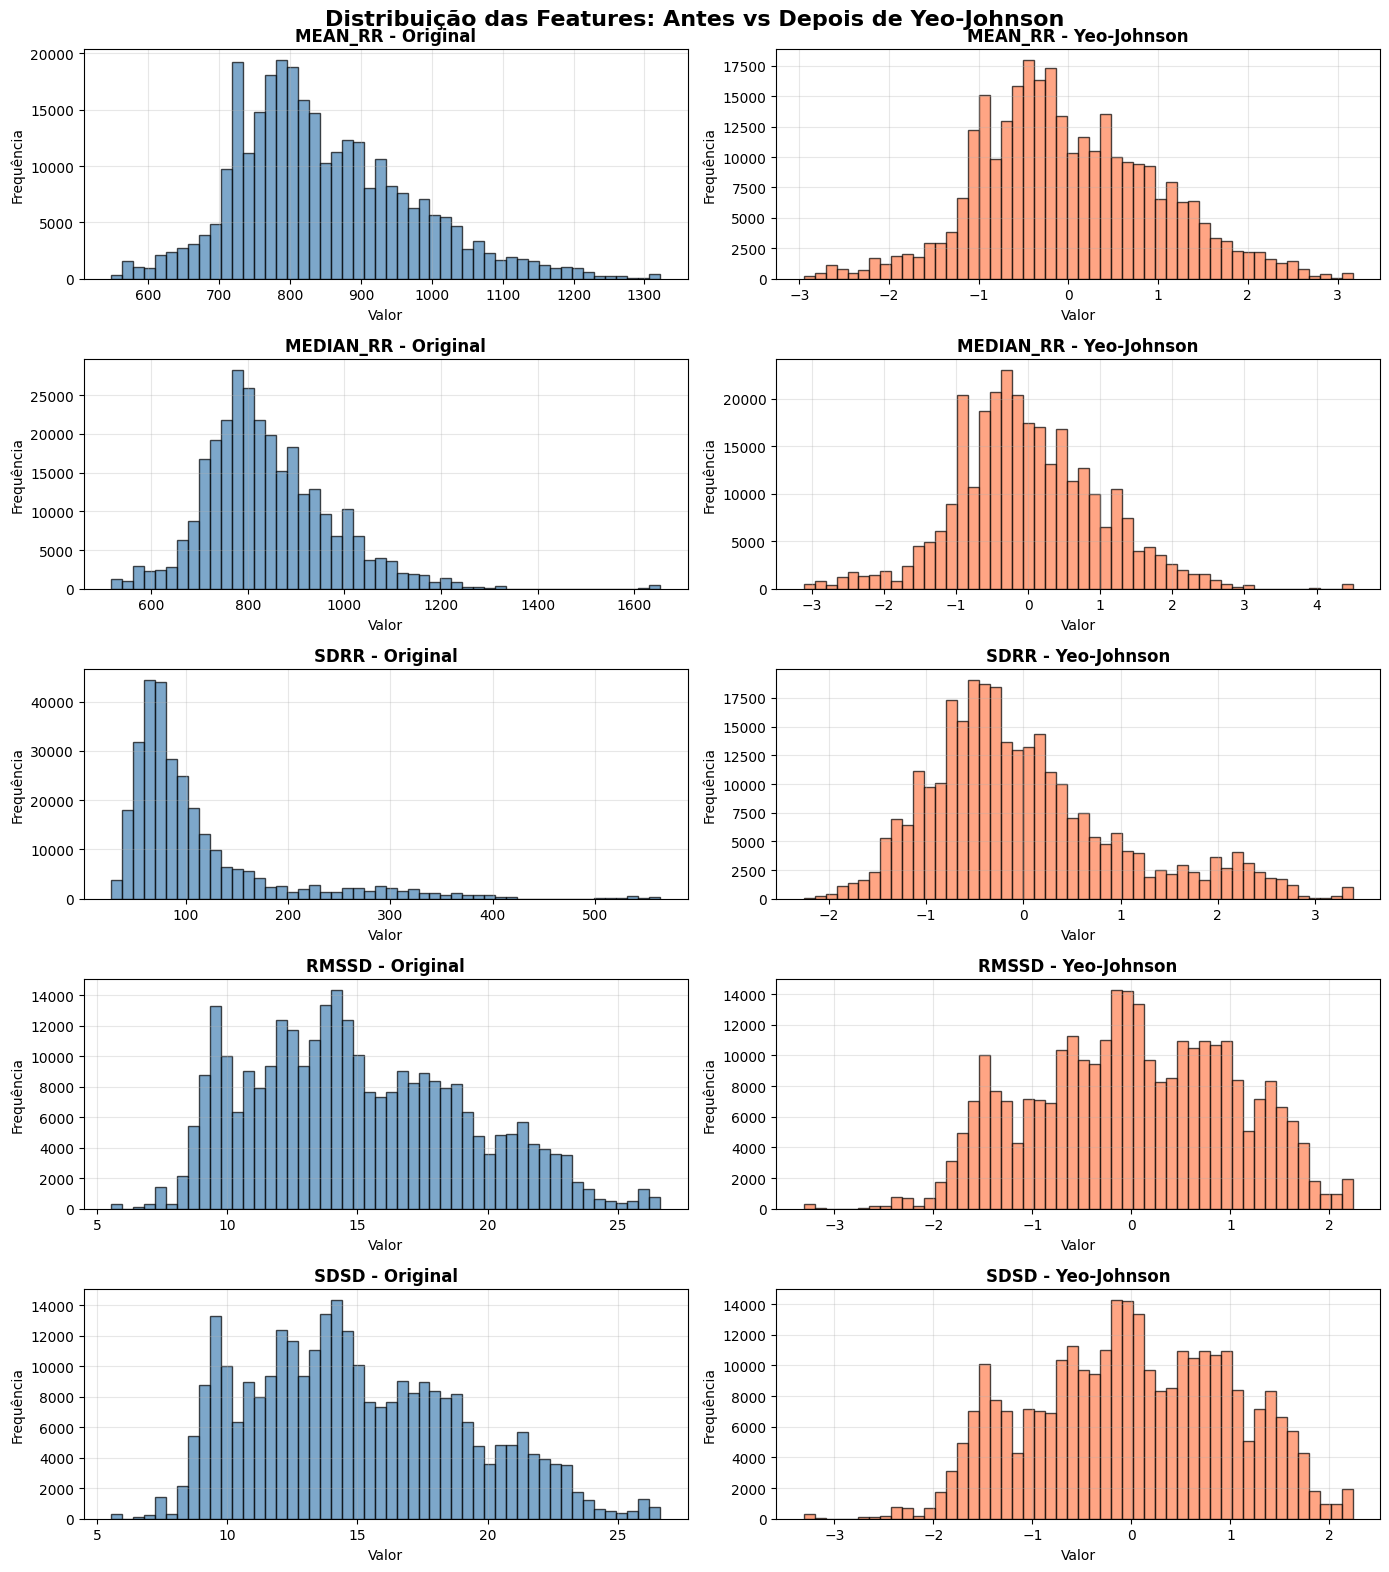

✅ Visualização completa! Total de features: 35


In [45]:
# Comparação das distribuições: antes e depois de Yeo-Johnson
fig, axes = plt.subplots(5, 2, figsize=(14, 16))
fig.suptitle('Distribuição das Features: Antes vs Depois de Yeo-Johnson', fontsize=16, fontweight='bold')

# Seleciona as primeiras 5 features para visualização
features = XTrainRaw.columns[:5]

for idx, feature in enumerate(features):
    # Antes (raw)
    axes[idx, 0].hist(XTrainRaw[feature], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'{feature} - Original', fontweight='bold')
    axes[idx, 0].set_xlabel('Valor')
    axes[idx, 0].set_ylabel('Frequência')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Depois (transformado)
    axes[idx, 1].hist(XTrain[feature], bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[idx, 1].set_title(f'{feature} - Yeo-Johnson', fontweight='bold')
    axes[idx, 1].set_xlabel('Valor')
    axes[idx, 1].set_ylabel('Frequência')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Salvar a figura
caminho_figura = 'yeo_johnson_distribuicao.png'
plt.savefig(caminho_figura, dpi=300, bbox_inches='tight')
print(f"✅ Imagem salva como: {caminho_figura}")

plt.show()

print(f"✅ Visualização completa! Total de features: {XTrain.shape[1]}")

In [ ]:
# ETAPA 1.5 | Exportar dados processados em CSV

# Criar diretório para salvar dados processados
dados_dir = 'dados_processados'
if not os.path.exists(dados_dir):
    os.makedirs(dados_dir)
    print(f"✅ Diretório '{dados_dir}' criado")

# Salvar como CSV (leitura fácil em qualquer plataforma)
XTrain.to_csv(f'{dados_dir}/XTrain.csv', index=False)
XTest.to_csv(f'{dados_dir}/XTest.csv', index=False)
pd.DataFrame(YTrain, columns=['HR']).to_csv(f'{dados_dir}/YTrain.csv', index=False)
pd.DataFrame(YTest, columns=['HR']).to_csv(f'{dados_dir}/YTest.csv', index=False)

# Salvar também os dados brutos (sem transformação)
XTrainRaw.to_csv(f'{dados_dir}/XTrainRaw.csv', index=False)
XTestRaw.to_csv(f'{dados_dir}/XTestRaw.csv', index=False)

print("✅ Dados processados salvos como CSV:")
print(f"   - {dados_dir}/XTrain.csv (features processadas)")
print(f"   - {dados_dir}/XTest.csv (features processadas)")
print(f"   - {dados_dir}/YTrain.csv (variável alvo treino)")
print(f"   - {dados_dir}/YTest.csv (variável alvo teste)")
print(f"\n✅ Dados brutos também salvos:")
print(f"   - {dados_dir}/XTrainRaw.csv")
print(f"   - {dados_dir}/XTestRaw.csv")

print(f"\n📊 Resumo dos dados salvos:")
print(f"   XTrain: {XTrain.shape}")
print(f"   XTest: {XTest.shape}")
print(f"   YTrain: {YTrain.shape}")
print(f"   YTest: {YTest.shape}")

✅ Diretório 'dados_processados' criado
✅ Dados salvos como CSV:
   - dados_processados/XTrain.csv
   - dados_processados/XTest.csv
   - dados_processados/YTrain.csv
   - dados_processados/YTest.csv

✅ Dados salvos como Pickle (completo):
   - dados_processados/dados_processados.pkl

✅ Scaler salvo:
   - dados_processados/scaler.joblib

📊 Resumo dos dados salvos:
   XTrain: (295431, 35)
   XTest: (73858, 35)
   YTrain: (295431, 1)
   YTest: (73858, 1)
✅ Dados salvos como CSV:
   - dados_processados/XTrain.csv
   - dados_processados/XTest.csv
   - dados_processados/YTrain.csv
   - dados_processados/YTest.csv

✅ Dados salvos como Pickle (completo):
   - dados_processados/dados_processados.pkl

✅ Scaler salvo:
   - dados_processados/scaler.joblib

📊 Resumo dos dados salvos:
   XTrain: (295431, 35)
   XTest: (73858, 35)
   YTrain: (295431, 1)
   YTest: (73858, 1)


## 📌 Como usar os dados processados em outro notebook

### Carregar arquivos CSV
```python
import pandas as pd

# Dados processados (após transformação e padronização)
XTrain = pd.read_csv('dados_processados/XTrain.csv')
XTest = pd.read_csv('dados_processados/XTest.csv')
YTrain = pd.read_csv('dados_processados/YTrain.csv').values
YTest = pd.read_csv('dados_processados/YTest.csv').values

# Dados brutos (antes das transformações)
XTrainRaw = pd.read_csv('dados_processados/XTrainRaw.csv')
XTestRaw = pd.read_csv('dados_processados/XTestRaw.csv')
```